# Tutorial III: Using Runner Advanced I

The purpose of this tutorial is to learn more about combining error generation with our Runner and using it to compare differend ML models' performance with errorified data. In this tutorial, instead of MNIST dataset, we'll be using smaller 8x8 images of handwritten digits for performance reasons. The usecase is comparing some clustering algorithms using data with different amount of error.


First we have to import the required modules. Let's also disable some annoying warnings.

In [1]:
import warnings
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import numpy as np
from hdbscan import HDBSCAN
from numba.errors import NumbaDeprecationWarning, NumbaWarning
from numpy.random import RandomState
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

from dpemu import runner
from dpemu.dataset_utils import load_digits_
from dpemu.filters.common import Missing
from dpemu.ml_utils import reduce_dimensions
from dpemu.nodes import Array
from dpemu.plotting_utils import visualize_scores, visualize_classes, \
    print_results_by_model

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=NumbaWarning)

/home/thalvari/PycharmProjects/dpEmu/venv/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/thalvari/PycharmProjects/dpEmu/venv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


The first phase of our pipeline is loading the dataset. The smaller Digits dataset contains 1797 images.

In [2]:
def get_data():
    return load_digits_()

Next we have to define our root node for error generation. Now the data is in one huge Numpy array and each row contains all pixel values for one image. Thus the root node's type needs to be Array. As for filters, we'll be using the Missing filter from the previous tutorial.

In [3]:
def get_err_root_node():
    err_root_node = Array()
    err_root_node.addfilter(Missing("probability", "missing_value_id"))
    return err_root_node

In this step we are defining the different error parameters for our filter we want to test the ML models with.

In [4]:
def get_err_params_list(data):
    p_steps = np.linspace(0, .5, num=6)
    err_params_list = [{"probability": p, "missing_value_id": 0} for p in p_steps]
    return err_params_list


The preprocessor code is run only once after the errorified data is generated, but before any of the ML models. The purpose of a preprocessor is to modify the errorified data to a usable format for the ML models. In this example we are using our premade pipeline for dimensionality reduction. Note that every dictionary element you add to the last return parameter will create a new column in the resulting Dataframe returned by the Runner. In this tutorial we will be using the reduced errorified data in our visualizations. 

In [5]:
class Preprocessor:
    def __init__(self):
        self.random_state = RandomState(42)

    def run(self, _, data, params):
        reduced_data = reduce_dimensions(data, self.random_state)
        return None, reduced_data, {"reduced_data": reduced_data}

Next we have to define the ML models. Every model has to have a public run method, which gets the preprocessed data. Similarly to the Preprocessor, the run method here also returns a dictionary and every added key will create a new column in the resulting Dataframe returned by the Runner. In this tutorial we'll be testing two different clustering algorithms, the other with two different parameters, and use AMI and ARI scores for comparison. The labels are only used for calculating the scores and unlike HDBSCAN, KMeans needs to know the desired number of clusters. HDBSCAN's min_cluster_size give the smallest size of a group of datapoints that can be considered a cluster.

In [6]:
class AbstractModel(ABC):

    def __init__(self):
        self.random_state = RandomState(42)

    @abstractmethod
    def get_fitted_model(self, data, params):
        pass

    def run(self, _, data, params):
        labels = params["labels"]
        fitted_model = self.get_fitted_model(data, params)
        return {
            "AMI": round(adjusted_mutual_info_score(labels, fitted_model.labels_, average_method="arithmetic"), 3),
            "ARI": round(adjusted_rand_score(labels, fitted_model.labels_), 3),
        }


class KMeansModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, data, params):
        labels = params["labels"]
        n_classes = len(np.unique(labels))
        return KMeans(n_clusters=n_classes, random_state=self.random_state).fit(data)


class HDBSCANModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, data, params):
        return HDBSCAN(
            min_cluster_size=params["min_cluster_size"],
            min_samples=1
        ).fit(data)

In this step we are defining the hyperparameters used by our models. This function returns a list of model/params_list pairs. Our Runner runs every model in this list with all different sets of hyperparameters listed in the corresponding params_list -element. The scores for each model/params pair will become rows in the resulting Dataframe.

In [7]:
def get_model_params_dict_list(data, labels):
    return [
        {"model": KMeansModel, "params_list": [{"labels": labels}]},
        {"model": HDBSCANModel, "params_list": [{"min_cluster_size": 25, "labels": labels}]},
        {"model": HDBSCANModel, "params_list": [{"min_cluster_size": 50, "labels": labels}]},
    ]

Next we have to choose the visualizations we want to perform on our data and results. Certainly we would like to visualize the scores for each model given the amount of error. We could also just visualize the dataset in 2D using the reduced_data column we added to the Dataframe.

In [8]:
def visualize(df, label_names, dataset_name, data):
    visualize_scores(
        df,
        score_names=["AMI", "ARI"],
        is_higher_score_better=[True, True],
        err_param_name="probability",
        title=f"{dataset_name} clustering scores with missing pixels",
    )
    visualize_classes(
        df,
        label_names,
        err_param_name="probability",
        reduced_data_column="reduced_data",
        labels_column="labels",
        cmap="tab10",
        title=f"{dataset_name} (n={data.shape[0]}) classes with missing pixels"
    )
    plt.show()

Now basically all that is left is asking the Runner to run our pipeline. Since we are doing unsupervised learning, training data won't be needed. By default Runner creates a subprocess for each element in err_params_list.

In [9]:
def main():
    data, labels, label_names, dataset_name = get_data()

    df = runner.run(
        train_data=None,
        test_data=data,
        preproc=Preprocessor,
        preproc_params=None,
        err_root_node=get_err_root_node(),
        err_params_list=get_err_params_list(data),
        model_params_dict_list=get_model_params_dict_list(data, labels),
    )

    print_results_by_model(df, ["missing_value_id", "labels", "reduced_data"])
    visualize(df, label_names, dataset_name, data)

Let's check out the results. HDBSCAN seems to perform better with little error and KMeans the other way around. Also HDBSCAN seems to perform better on average if min_cluster_size isn't too small.

100%|██████████| 6/6 [00:47<00:00, 12.32s/it]


HDBSCAN #1
     AMI    ARI  min_cluster_size  probability  time_err  time_mod   time_pre
0  0.869  0.810              25.0          0.0  0.024347  0.060289  31.692205
1  0.815  0.766              25.0          0.1  0.011914  0.261374  31.810758
2  0.619  0.465              25.0          0.2  0.036813  0.189780  31.839864
3  0.525  0.422              25.0          0.3  0.030382  0.065639  30.501198
4  0.348  0.195              25.0          0.4  0.027822  0.040710  15.640825
5  0.017  0.000              25.0          0.5  0.015156  0.036913  15.682822
HDBSCAN #2
     AMI    ARI  min_cluster_size  probability  time_err  time_mod   time_pre
0  0.908  0.883              50.0          0.0  0.024347  0.055217  31.692205
1  0.821  0.779              50.0          0.1  0.011914  0.217980  31.810758
2  0.667  0.597              50.0          0.2  0.036813  0.112301  31.839864
3  0.530  0.432              50.0          0.3  0.030382  0.111429  30.501198
4  0.359  0.237              50.0         

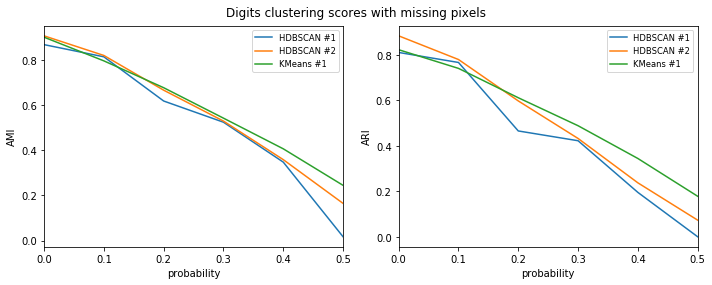

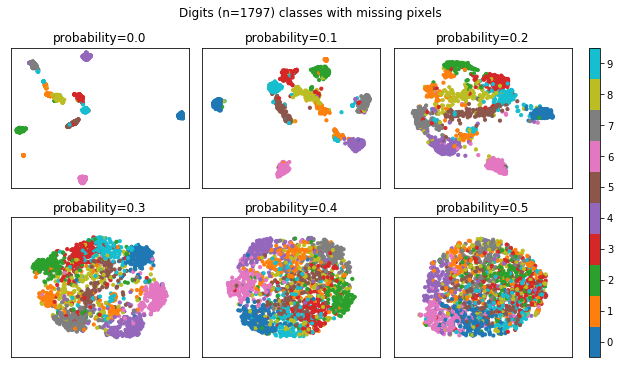

In [10]:
main()

The notebook for this tutorial can be found [here](https://github.com/dpEmu/dpEmu/blob/master/docs/tutorials/Using_Runner_Advanced_I.ipynb).